# CCE Gridded Data Processing - Converting file format to netcdf

**Purpose**: Code for converting the mat files into netcdf format

**Luke Colosi | lcolosi@ucsd.edu**

Import libraries

In [1]:
import xarray as xr
from scipy.io import loadmat
import numpy as np
import os
from datetime import datetime, timedelta
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import gsw
from netCDF4 import Dataset, num2date

Set the path to aviso data set

In [2]:
# Set processing parameters
option_mooring = 'CCE1'

# Set time and space parameters
T = 1                                            # Specifies the duration of the bin averaging (units: hours)
start_time = datetime(2016, 1, 1, 0, 0, 0)       # Specifies the start time of the event period
end_time = datetime(2017, 12, 31, 23, 59, 59)    # Specifies the end time of the event period
event_time_bnds = [start_time, end_time]         # Specifies the event period
depth_bins = np.array([10,20,30,40,60,75,150,300,550,750,1000,2200,3900]) # Specifies the depths

# Set path and file name
PATH = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/data/CCE/' + option_mooring + '/CTD/'
if option_mooring == 'CCE1':
    file_name = 'cce1_gridded_TS.mat' 
elif option_mooring == 'CCE2':
    file_name = 'cce2_gridded_TS.mat' 

Convert .mat file into a netcdf using xarray

In [3]:
# Read in data as a dictionary
data = loadmat(PATH + file_name)

# Set variabile names
vars = list(data.keys())

# ----------------------------------------------------------------
# STEP 1 - Extract data from mat file
# ----------------------------------------------------------------

# Assign variables
depth      = data[vars[3]].flatten()
sal_r      = data[vars[4]]
temp_r     = data[vars[5]]
time_r     = data[vars[6]][0]

# Convert the time series to datetime 
time_dt = np.array([datetime.fromordinal(int(float(d))) + 
                    timedelta(days=float(d) % 1) - 
                    timedelta(days=366)
                    for d in time_r ])

#--- Notes ---# 
# MATLAB datenum 1 == 0000-01-01, but Python's datetime starts at 0001-01-01,
# so we need to subtract 366 days to shift the epoch.

# ----------------------------------------------------------------
# STEP 2 - Extract data from specified time period
# ----------------------------------------------------------------

# Find indicies where data is between time bounds
idx_time = (time_dt >= event_time_bnds[0]) & (time_dt <= event_time_bnds[1]) 

# Index data
time    = time_dt[idx_time]
sal_n   = sal_r[:,idx_time]
temp_n  = temp_r[:,idx_time]

# ----------------------------------------------------------------
# STEP 3 - Extract data from specified depths
# ----------------------------------------------------------------

# Initialize array
temp_at_bins = np.full((len(depth_bins), temp_n.shape[1]), np.nan)
sal_at_bins = np.full((len(depth_bins), sal_n.shape[1]), np.nan)

# Loop over each depth bin and extract closest depth match
for i, target_depth in enumerate(depth_bins):
    
    # Find index of the closest depth
    idx = np.argmin(np.abs(depth - target_depth))
    
    # Assign the corresponding temperature time series
    temp_at_bins[i, :] = temp_n[idx, :]
    sal_at_bins[i, :] = sal_n[idx, :]

# Convert NaNs to masked arrays
temp = np.ma.masked_invalid(temp_at_bins)
sal = np.ma.masked_invalid(sal_at_bins)

# # ----------------------------------------------------------------
# # STEP 3 - Linearly interpolate over NaNs
# # ----------------------------------------------------------------

# # Initialize array
# ndepth,ntime = np.shape(temp_at_bins)
# temp = np.ma.masked_all((ndepth, ntime))
# sal = np.ma.masked_all((ndepth, ntime))

# # Convert datetime array to float (e.g., seconds since first time)
# time_seconds = np.array([(t - time[0]).total_seconds() for t in time])

# # Loop over depth 
# for i in range(0,len(depth_bins)):

#     # Find valid indices
#     valid_temp = ~np.isnan(temp_at_bins[i,:])
#     valid_sal = ~np.isnan(sal_at_bins[i,:])

#     # Linearly interpolate
#     temp[i, :] = np.interp(time_seconds, time_seconds[valid_temp], temp_at_bins[i,valid_temp])
#     sal[i, :] = np.interp(time_seconds, time_seconds[valid_sal], sal_at_bins[i,valid_sal])


Plot temperature and salinity data

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_31535/3756347330.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


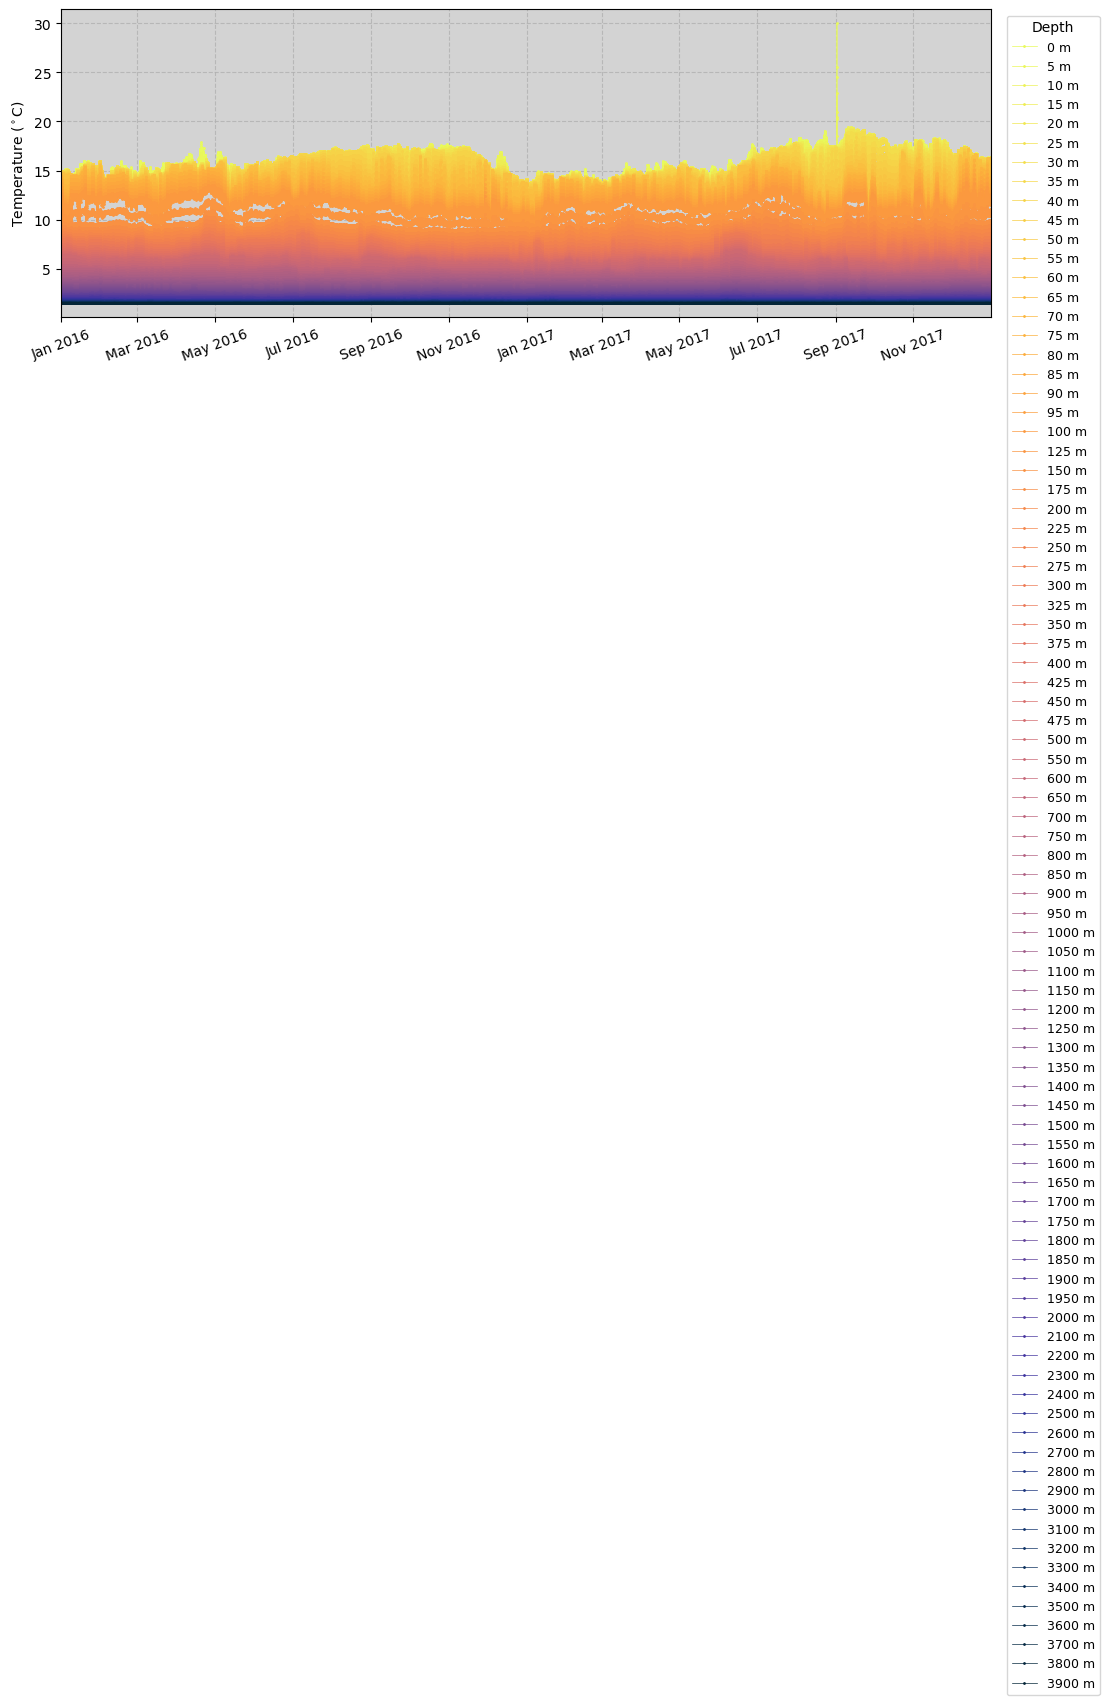

In [6]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Set colormap fro depths
cmap = cmocean.cm.thermal.reversed()
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(time, temp_n[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax.set_ylabel(r"Temperature ($^\circ$C)")
ax.set_xlim(time[0], time[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

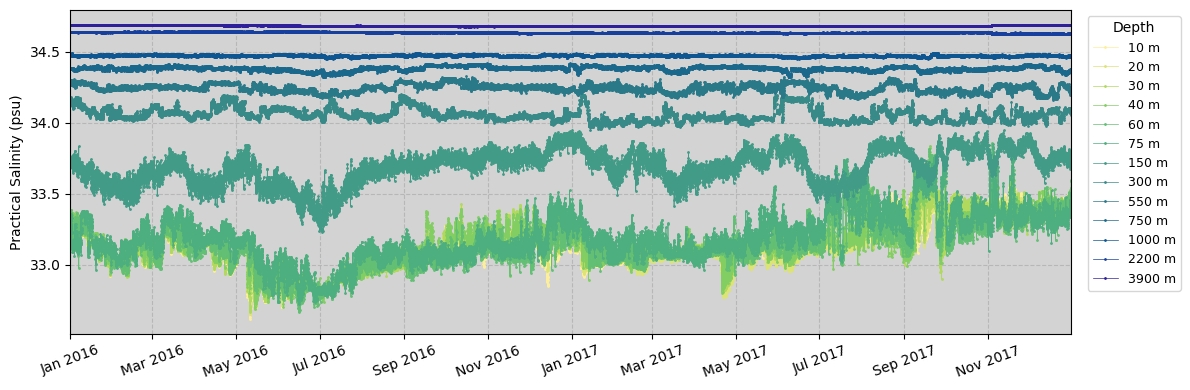

In [5]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 4))

# Set colormap from depths
cmap = cmocean.cm.haline.reversed()
colors = [cmap(i / len(depth_bins)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth_bins):
    ax.plot(time, sal[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Set axis attributes
ax.set_ylabel(r"Practical Salinity (psu)")
ax.set_xlim(time[0], time[-1])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=20)
ax.grid(True, linestyle='--', alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Load in processed data from raw data for latitutude and longitude of mooring

In [6]:
# Set the file name and read in the data file
filename_CCE = PATH + option_mooring + "_CTD_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_data.nc"
nc_CCE = Dataset(filename_CCE, 'r')

# Extract data variables
lon_m             = nc_CCE.variables['LON'][:]
lat_m             = nc_CCE.variables['LAT'][:]

Compute potential density at several reference levels

In [7]:
# Set dimnesions
ndepth,ntime = np.shape(temp)

# Convert depths to the coordinate system with positive z up 
depth_conv = -1 * depth_bins  # Units: m

# Initialize an array for the pressure, conservative temperature, absolute salinity, and in-situ/potential density 
pres     = np.zeros_like(temp)
CT       = np.zeros_like(temp)
SA       = np.zeros_like(temp)
density  = np.zeros_like(temp)
sigma0   = np.zeros_like(temp)
sigma1   = np.zeros_like(temp)
sigma2   = np.zeros_like(temp)
sigma3   = np.zeros_like(temp)

# Loop through time steps 
for idata in range(0,ntime):

    # Compute pressure from depth and latitude
    pres[:,idata] = gsw.conversions.p_from_z(depth_conv,lat_m)  # Units: dbar

    # Compute absolute salinity 
    SA[:,idata] = gsw.conversions.SA_from_SP(sal[:,idata], pres[:,idata], lon_m, lat_m) # Units: g/kg

    # Compute Conservative temperature from absolute salinity, in-situ temperature and pressure
    CT[:,idata] = gsw.conversions.CT_from_t(SA[:,idata], temp[:,idata], pres[:,idata])  # Units: degrees Celcius

    # Compute in-situ and potential density (with reference pressure of 0 dbar) 
    density[:,idata] = gsw.density.rho(SA[:,idata],CT[:,idata],pres[:,idata])  # Units: kg/m^3
    sigma0[:,idata] = gsw.density.sigma0(SA[:,idata], CT[:,idata])  # Units: kg/m^3
    sigma1[:,idata] = gsw.density.sigma1(SA[:,idata], CT[:,idata])  # Units: kg/m^3
    sigma2[:,idata] = gsw.density.sigma2(SA[:,idata], CT[:,idata])  # Units: kg/m^3
    sigma3[:,idata] = gsw.density.sigma0(SA[:,idata], CT[:,idata])  # Units: kg/m^3

Save data in a netcdf file

In [8]:
# Save variables in data arrays

#--- Sea State Varibles ---# 
Pressure = xr.DataArray(data=pres, 
                    dims=['depth','time',],
                    coords=dict(depth=depth_bins,time=time),
                    attrs=dict(
                        description='Pressure profiles time series.',
                        units='dbar'
                        )
)

Density = xr.DataArray(data=density, 
                    dims=['depth','time',],
                    coords=dict(depth=depth_bins,time=time),
                    attrs=dict(
                        description='In-situ Density profiles time series.',
                        units='kg/m^3'
                        )
) 

SIG0 = xr.DataArray(data=sigma0, 
                    dims=['depth','time',],
                    coords=dict(depth=depth_bins,time=time),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at the sea surface.',
                        units='kg/m^3'
                        )
) 

SIG1 = xr.DataArray(data=sigma1, 
                    dims=['depth','time',],
                    coords=dict(depth=depth_bins,time=time),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at 1000 meters.',
                        units='kg/m^3'
                        )
) 

SIG2 = xr.DataArray(data=sigma2, 
                    dims=['depth','time',],
                    coords=dict(depth=depth_bins,time=time),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at 2000 meters.',
                        units='kg/m^3'
                        )
) 

SIG3 = xr.DataArray(data=sigma3, 
                    dims=['depth','time',],
                    coords=dict(depth=depth_bins,time=time),
                    attrs=dict(
                        description='Potential Density anomaly profiles referenced to the pressure at 3000 meters.',
                        units='kg/m^3'
                        )
) 

CTemp = xr.DataArray(data=CT, 
                    dims=['depth','time',],
                    coords=dict(depth=depth_bins,time=time),
                    attrs=dict(
                        description='Conservative temperature profiles time series.',
                        units='degrees Celcius'
                        )
) 

ASal = xr.DataArray(data=SA, 
                    dims=['depth','time',],
                    coords=dict(depth=depth_bins,time=time),
                    attrs=dict(
                        description='Absolute Salinity profiles time series.',
                        units='g/kg'
                        )
) 

#--- Latitude and Longitude Positions of the Mooring ---# 
LON = xr.DataArray(data=lon_m[0], 
                    dims=[],  # scalar: no dimension
                    attrs=dict(
                        description='Longitude of the mooring.'
                        )
) 

LAT = xr.DataArray(data=lat_m[0], 
                    dims=[],  # scalar: no dimension
                    attrs=dict(
                        description='Latitude of mooring.'
                        )
) 

# Create a data set from data arrays 
data = xr.Dataset({'Pressure':Pressure,'Density':Density,'SIG0':SIG0,'SIG1':SIG1,'SIG2':SIG2,'SIG3':SIG3,'CTemp':CTemp,'ASal':ASal,'LON':LON,'LAT':LAT})

# Check if file exists, then delete it
file_path = PATH + option_mooring + "_CTD_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_gridded_data.nc"
if os.path.exists(file_path):
    os.remove(file_path)

# Create netcdf file
data.to_netcdf(file_path,mode='w')

### Important Notes

1. I did not interpolate onto a regular hourly grid because the temperature and Salinity data was already on a regular 1 hourly grid. To see this run the following code to check the timer duration between data points in the time series: 

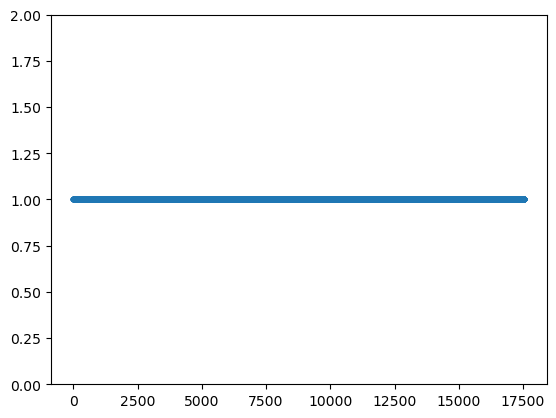

In [9]:
dt = np.diff(time)

dt_hours = np.array([d.total_seconds() for d in dt]) * (1/60) * (1/60)

plt.plot(dt_hours,'.')
plt.ylim(0,2)
plt.show()

2. All depths except the top two bins (0 and 5 meter depths) had nearly a full time series. Picked bins with the least gaps and interpolated in time over these gaps

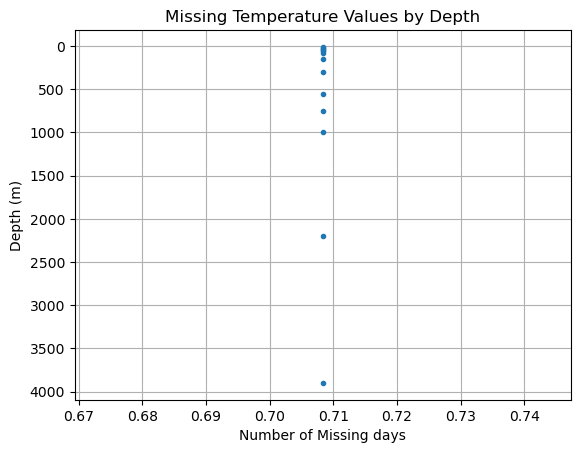

In [10]:
# Step 1: Flatten time and compute median time step in seconds
time_flat = time.flatten()
dt_sec = np.median(np.diff(time_flat))  # Time step in seconds

# Step 2: Convert time step to days
dt_days = dt_sec.total_seconds() / (60 * 60 * 24)

# Step 3: Count Masked per depth
n_missing_per_depth = np.sum(temp.mask, axis=1)

# Step 4: Convert to number of missing days
missing_days = n_missing_per_depth * dt_days

plt.plot(missing_days, depth_bins,'.')  # depth_1d from earlier
plt.gca().invert_yaxis()  # Depth increases downward
#plt.xlim(0,1)
plt.xlabel('Number of Missing days')
plt.ylabel('Depth (m)')
plt.title('Missing Temperature Values by Depth')
plt.grid(True)
plt.show()

In [11]:
print(n_missing_per_depth)

[17 17 17 17 17 17 17 17 17 17 17 17 17]
